# Initial Set up

In [183]:
import pandas as pd
import matplotlib.pyplot as plt
LABELED_PATH = "../data/processed/wintermute_transfers_clean_defi.parquet"  # adjust if you used .csv
df_defi = pd.read_parquet(LABELED_PATH)
display(df_defi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365667 entries, 0 to 365666
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     365667 non-null  object 
 1   from_address  365667 non-null  object 
 2   from_entity   365667 non-null  object 
 3   to_address    365667 non-null  object 
 4   to_entity     365667 non-null  object 
 5   token         365667 non-null  object 
 6   value         365667 non-null  float64
 7   usd           365667 non-null  float64
 8   tx_hash       365667 non-null  object 
 9   chain         365667 non-null  object 
 10  block_number  365667 non-null  float64
dtypes: float64(3), object(8)
memory usage: 30.7+ MB


None

In [184]:
df_defi_from = df_defi[df_defi['from_entity']!='Wintermute']
df_defi_from = df_defi_from.rename(columns={"from_address": "address", "from_entity": "entity"})

df_defi_to = df_defi[df_defi['to_entity']!='Wintermute']
df_defi_to = df_defi_to.rename(columns={"to_address": "address", "to_entity": "entity"})

df_defi_non_wintermute = (
    pd.concat([df_defi_from, df_defi_to], ignore_index=True)
      .drop(columns=['from_address','from_entity',
                    'to_address','to_entity'])
      .reset_index(drop=True)
      .sort_values('entity')
)
display(df_defi_non_wintermute.info())

<class 'pandas.core.frame.DataFrame'>
Index: 365667 entries, 9063 to 348825
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     365667 non-null  object 
 1   address       365667 non-null  object 
 2   entity        365667 non-null  object 
 3   token         365667 non-null  object 
 4   value         365667 non-null  float64
 5   usd           365667 non-null  float64
 6   tx_hash       365667 non-null  object 
 7   chain         365667 non-null  object 
 8   block_number  365667 non-null  float64
dtypes: float64(3), object(6)
memory usage: 27.9+ MB


None

# Summary

In [185]:
df_defi['timestamp'] = pd.to_datetime(df_defi["timestamp"],  utc=True, errors="coerce")
df_defi = df_defi.set_index("timestamp").sort_index()

df_defi_non_wintermute['timestamp'] = pd.to_datetime(df_defi_non_wintermute["timestamp"],  utc=True, errors="coerce")
df_defi_non_wintermute = df_defi_non_wintermute.set_index("timestamp").sort_index()

In [186]:
summary = {
    "total_txns": [len(df_defi)],
    "start period": [df_defi.index.min()],
    "end period": [df_defi.index.max()],
    "chains": [df_defi['chain'].nunique()],
    "entities": [df_defi_non_wintermute['entity'].nunique()],
    "tokens": [df_defi['token'].nunique()],
    "usd_volume_total": [df_defi['usd'].sum()],
    "min_txn_usd": [df_defi['usd'].min()],
    "median_txn_usd": [df_defi['usd'].median()],
    "mean_txn_usd": [df_defi['usd'].mean()],
    "max_txn_usd": [df_defi['usd'].max()],
}
df_summary = pd.DataFrame(summary)
df_summary

,total_txns,start period,end period,chains,entities,tokens,usd_volume_total,min_txn_usd,median_txn_usd,mean_txn_usd,max_txn_usd
0,365667,2025-04-08 01:30:11+00:00,2025-04-08 12:49:57+00:00,6,30,123,8.614034e+08,0.0,198.332886,2355.704462,1.210451e+07


# Time Series

## 1. Defi Volume (USD)

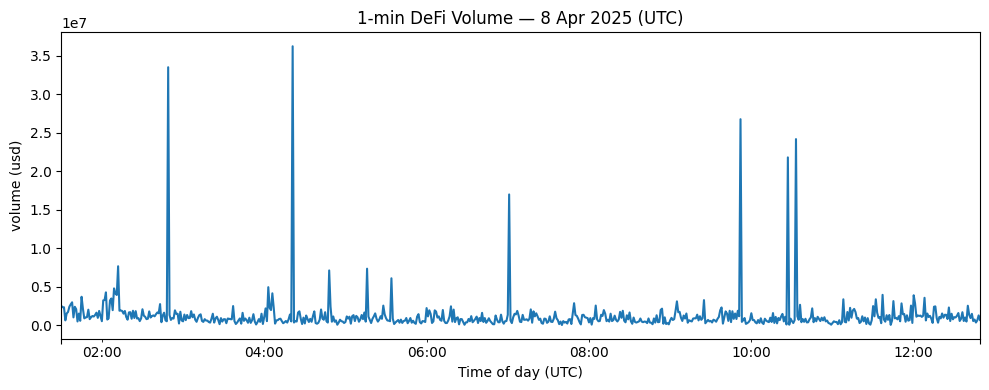

In [187]:
vol_1m = df_defi["usd"].abs().resample("1min").sum()
vol_1m.plot(figsize=(10,4), title="1-min DeFi Volume — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.tight_layout()
plt.savefig("../outputs/vol_1m.png", dpi=150)

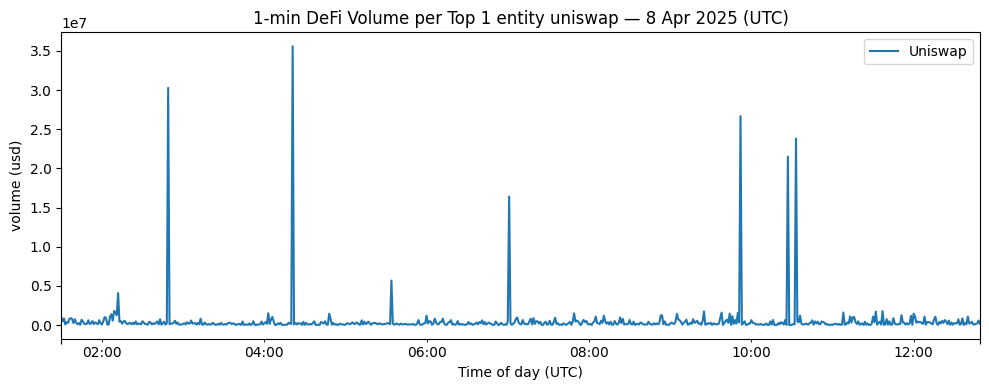

In [188]:
vol_1m_entity = (
    df_defi_non_wintermute                     
    .pivot_table(               
        values="usd",
        index=df_defi_non_wintermute.index,    
        columns="entity",    
        aggfunc="sum",
        fill_value=0,
    )
    .abs()                      
    .resample("1min")           
    .sum()
)
topN = 1
top_cols = (
    vol_1m_entity.sum().nlargest(topN).index
)
vol_1m_entity[top_cols].plot(figsize=(10,4), title="1-min DeFi Volume per Top 1 entity uniswap — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("../outputs/vol_1m.png", dpi=150)

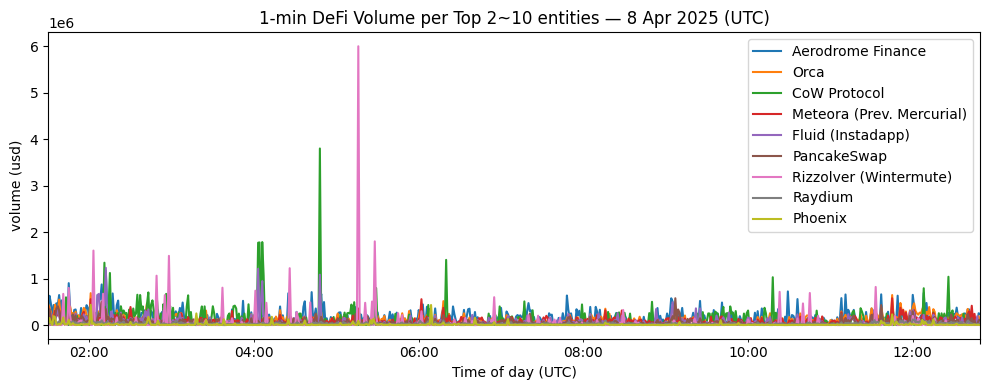

In [189]:
topN = 10
top_cols = (
    vol_1m_entity.sum().nlargest(topN).index
)[1:]
vol_1m_entity[top_cols].plot(figsize=(10,4), title="1-min DeFi Volume per Top 2~10 entities — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.legend(loc="best")
plt.tight_layout()
# plt.savefig("../outputs/vol_1m.png", dpi=150)

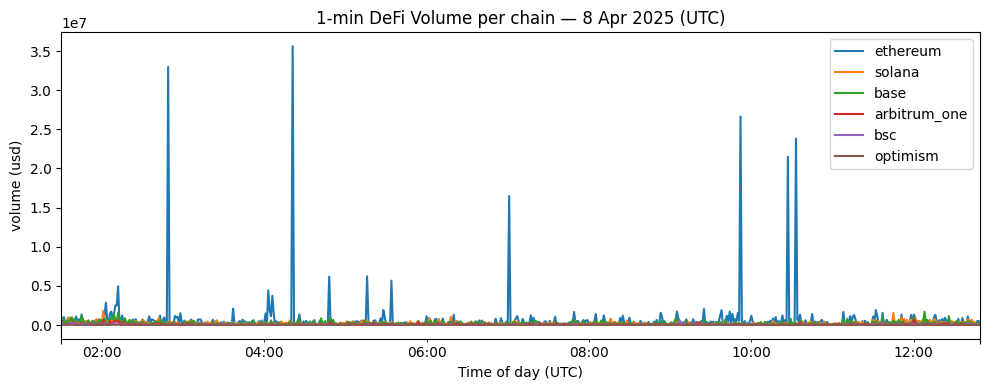

In [190]:
vol_1m_chain = (
    df_defi_non_wintermute                     
    .pivot_table(               
        values="usd",
        index=df_defi_non_wintermute.index,    
        columns="chain",    
        aggfunc="sum",
        fill_value=0,
    )
    .abs()                      
    .resample("1min")           
    .sum()
)
topN = 10
top_cols_chain = (
    vol_1m_chain.sum().nlargest(topN).index
)
vol_1m_chain[top_cols_chain].plot(figsize=(10,4), title="1-min DeFi Volume per chain — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.legend(loc="best")
plt.tight_layout()

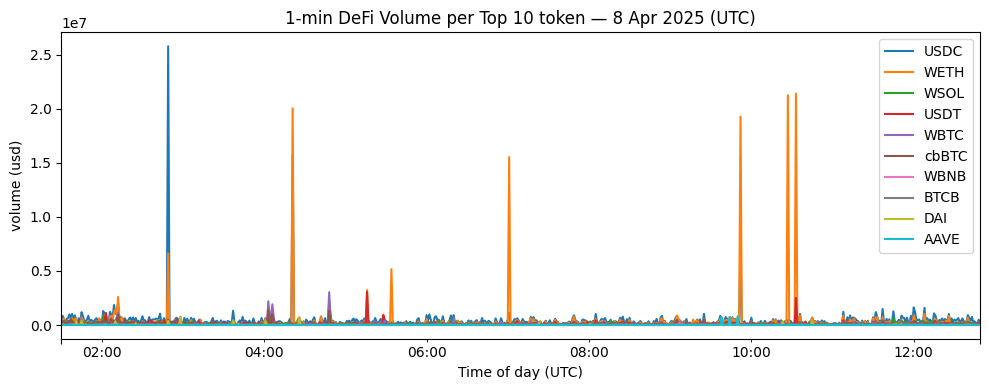

In [202]:
vol_1m_token = (
    df_defi_non_wintermute                     
    .pivot_table(               
        values="usd",
        index=df_defi_non_wintermute.index,    
        columns="token",    
        aggfunc="sum",
        fill_value=0,
    )
    .abs()                      
    .resample("1min")           
    .sum()
)
topN = 10
top_cols_token = (
    vol_1m_token.sum().nlargest(topN).index
)
vol_1m_token[top_cols_token].plot(figsize=(10,4), title="1-min DeFi Volume per Top 10 token — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.legend(loc="best")
plt.tight_layout()

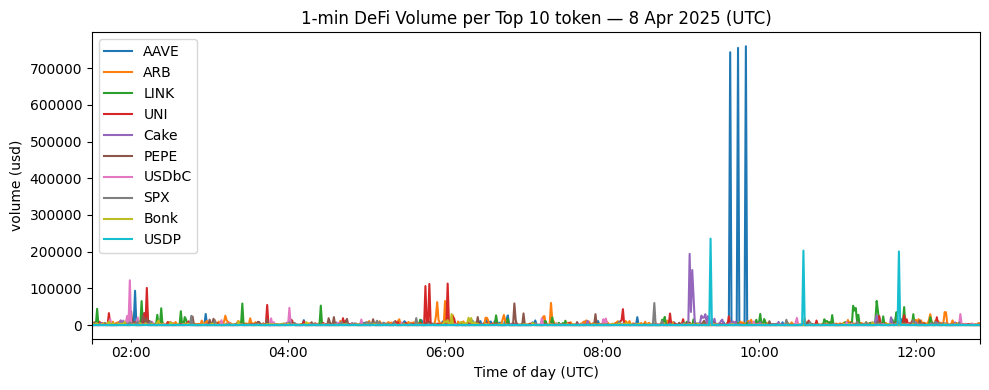

In [208]:
rail_tokens = ["USDC","WETH","WSOL","WBTC","cbBTC","WBNB",'USDT',"BTCB","DAI",'EURC','stETH','wstETH','USDS']
df_non_rail_tokens = df_defi_non_wintermute[~df_defi_non_wintermute["token"].isin(rail_tokens)]
vol_1m_token = (
    df_non_rail_tokens                     
    .pivot_table(               
        values="usd",
        index=df_non_rail_tokens.index,    
        columns="token",    
        aggfunc="sum",
        fill_value=0,
    )
    .abs()                      
    .resample("1min")           
    .sum()
)
topN = 10
top_cols_token = (
    vol_1m_token.sum().nlargest(topN).index
)
vol_1m_token[top_cols_token].plot(figsize=(10,4), title="1-min DeFi Volume per Top 10 token — 8 Apr 2025 (UTC)")
plt.ylabel("volume (usd)")
plt.xlabel("Time of day (UTC)")
plt.legend(loc="best")
plt.tight_layout()

- Baseline being non-zero positive values around 1e6 usd showing activity of market making strateigies.
- Huge spikes for each 45min to 1h. Half from Wintermute and the other half to Wintermute. This could mean either huge opportunities occured for market making strategies or a portfolio rebalancing conducted in regular times.

## 2. Defi Volume (tx-count)

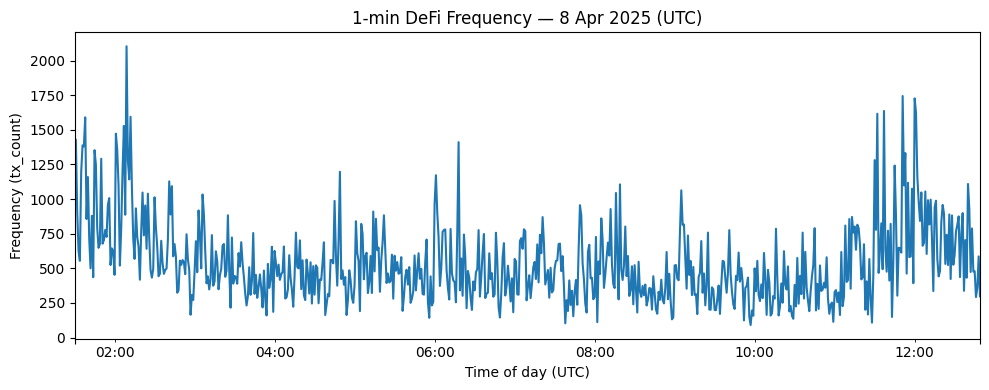

In [207]:
vol_1m_count = df_defi['usd'].resample("1min").count()
vol_1m_count.plot(figsize=(10,4), title="1-min DeFi Frequency — 8 Apr 2025 (UTC)")
plt.ylabel("Frequency (tx_count)")
plt.xlabel("Time of day (UTC)")
plt.tight_layout()
plt.savefig("../outputs/vol_1m_count.png", dpi=150)

## 3. Total count of protocals usage

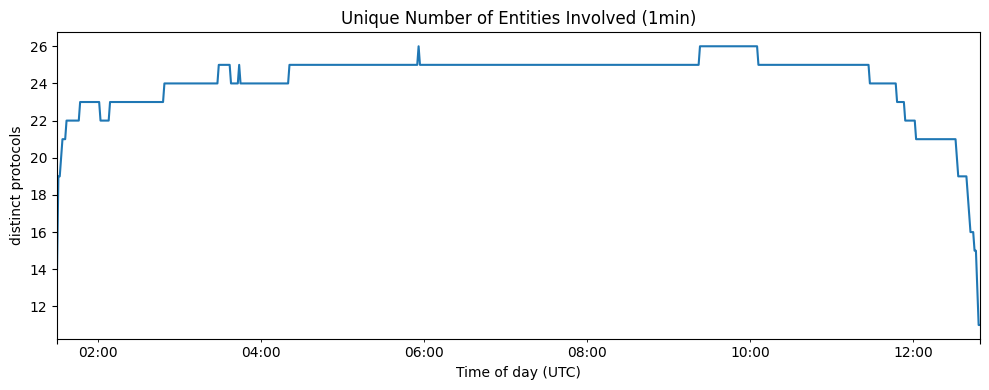

In [210]:
proto_1m = (
    df_defi_non_wintermute.groupby("entity")["usd"]              
      .resample("1min")                          
      .size()                                   
      .reset_index(name="txs")
      .set_index("timestamp")                   
      .resample("1min")["entity"]                
      .nunique()                                
)
proto_1m.plot(figsize=(10,4), title="Unique Number of Entities Involved (1min)")
plt.ylabel("distinct protocols")
plt.xlabel("Time of day (UTC)")
plt.tight_layout()
plt.savefig("../outputs/unique_entity_1m.png", dpi=150)

# Distribution of transaction volume (USD)

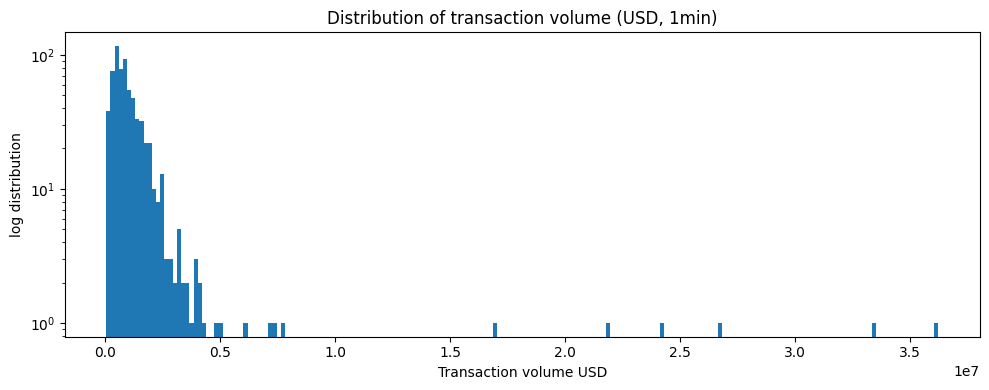

In [214]:
plt.figure(figsize=(10,4))
plt.hist(vol_1m, bins=200)
plt.yscale('log')
plt.xlabel("Transaction volume USD")
plt.ylabel("log distribution")
plt.title("Distribution of transaction volume (USD, 1min)")
plt.tight_layout()
plt.savefig("../outputs/volume_distribution_usd_1m.png", dpi=150)

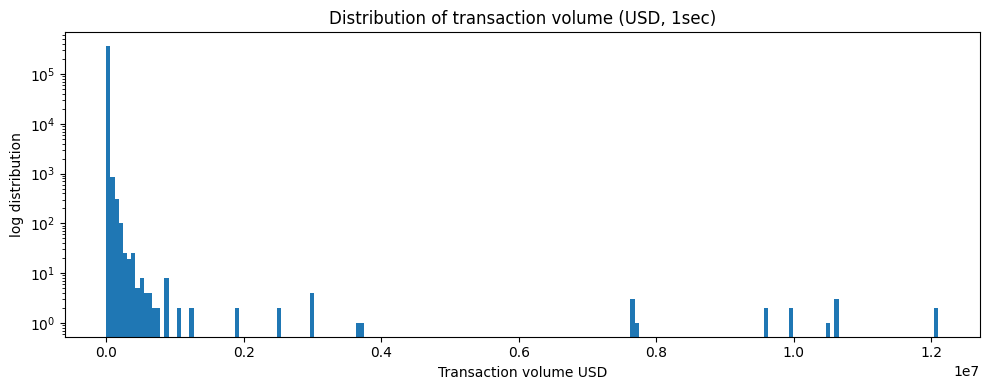

In [215]:
plt.figure(figsize=(10,4))
plt.hist(df_defi['usd'], bins=200)
plt.yscale('log')
plt.xlabel("Transaction volume USD")
plt.ylabel("log distribution")
plt.title("Distribution of transaction volume (USD, 1sec)")
plt.tight_layout()
plt.savefig("../outputs/volume_distribution_usd.png", dpi=150)

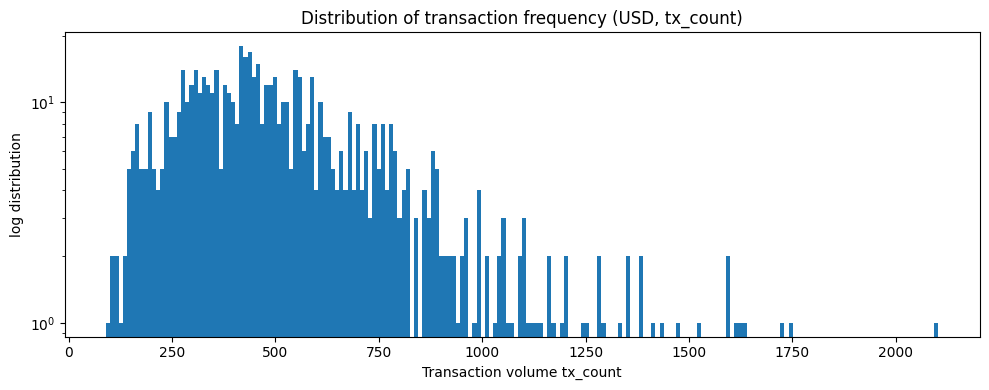

In [216]:
plt.figure(figsize=(10,4))
plt.hist(vol_1m_count, bins=200)
plt.yscale('log')
plt.xlabel("Transaction volume tx_count")
plt.ylabel("log distribution")
plt.title("Distribution of transaction frequency (USD, tx_count)")
plt.tight_layout()
plt.savefig("../outputs/volume_distribution_tx_count_1m.png", dpi=150)

# Large Transaction

In [198]:
large_tx = df_defi[df_defi['usd']>=5e6]
large_tx

,from_address,from_entity,to_address,to_entity,token,value,usd,tx_hash,chain,block_number
timestamp,,,,,,,,,,
2025-04-08 02:49:23+00:00,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,USDC,1.210451e+07,1.210451e+07,0x9e5d500d283fb88326339aae67aa7992d77062d62f21...,ethereum,22221298.0
2025-04-08 02:49:23+00:00,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,USDC,1.210259e+07,1.210259e+07,0xca1868177fc95f65cab8583e9d25493bdab4b3eb1b8c...,ethereum,22221298.0
2025-04-08 04:21:47+00:00,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,WETH,6.288516e+03,9.983271e+06,0x696199226ac1afa67b8df634cf8883a24a48ac2ae17f...,ethereum,22221758.0
2025-04-08 04:21:47+00:00,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,USDC,7.663052e+06,7.663052e+06,0x696199226ac1afa67b8df634cf8883a24a48ac2ae17f...,ethereum,22221758.0
2025-04-08 04:21:47+00:00,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,WETH,6.260118e+03,9.938188e+06,0xb1ba17f6ee9dc8757c835f4826e362dbc076a72afde3...,ethereum,22221758.0
2025-04-08 04:21:47+00:00,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,USDC,7.708227e+06,7.708227e+06,0xb1ba17f6ee9dc8757c835f4826e362dbc076a72afde3...,ethereum,22221758.0
2025-04-08 07:01:35+00:00,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,Uniswap,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,WETH,4.851548e+03,7.644924e+06,0xbfc2a6473e4f2f3d92b2c1a43e6308be9f6177638783...,ethereum,22222554.0
2025-04-08 07:01:35+00:00,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,Uniswap,WETH,4.852850e+03,7.646975e+06,0x8e42f375341346dacf2668633c021cc86b023f28a3e5...,ethereum,22222554.0
2025-04-08 09:52:23+00:00,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Uniswap,0x51c72848c68a965f66fa7a88855f9f7784502a7f,Wintermute,WETH,6.118176e+03,9.600641e+06,0x533fb24de197cd588cb16ffe52428957ff182cfc4203...,ethereum,22223407.0


# Token-Chain Heatmap

In [199]:
top_tokens = df_defi["token"].value_counts().head(10).index
mask = df_defi["token"].isin(top_tokens)
pivot = pd.crosstab(
    index   = df_defi.loc[mask, "token"].to_numpy(),
    columns = df_defi.loc[mask, "chain"].to_numpy(),
)
pivot

col_0,arbitrum_one,base,bsc,ethereum,optimism,solana
row_0,,,,,,
ARB,5159,0,0,0,0,0
JUP,0,0,0,0,0,2432
SOL,0,0,0,0,0,47688
USDC,30419,7406,0,2835,1315,66611
USDT,4668,0,2514,2015,8,7534
WBNB,0,0,2765,0,0,0
WBTC,4495,0,0,1299,0,6731
WETH,20672,7166,0,5866,1510,4178
WSOL,0,0,0,0,0,96212


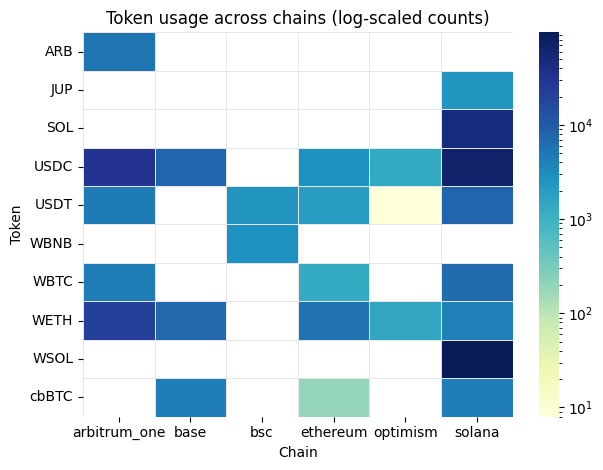

In [200]:
import seaborn as sns
import matplotlib.colors as mcolors

sns.heatmap(
    pivot,
    cmap="YlGnBu", 
    norm = mcolors.LogNorm(),
    linewidths=.5,
    linecolor="0.9",
)

plt.title("Token usage across chains (log-scaled counts)")
plt.ylabel("Token")
plt.xlabel("Chain")
plt.tight_layout()
plt.show()

# Entity Structure
- All transaction included with Wintermute; this is due to removal of unknown wallets without entities provided
- Was expecting to have Structure of: Wintermute EOA → Wintermute Resolver → Aggregator/Router → DEX Pools → Aggregator/Router → Wintermute EOA

In [201]:
entity_flows = (
    df_defi
    .groupby(['from_entity', 'to_entity'])
    .agg(
        total_usd=('usd', 'sum'), 
        tx_count=('tx_hash', 'nunique')
    )
    .sort_values('from_entity',ascending=False)
    .reset_index()
)
entity_flows

,from_entity,to_entity,total_usd,tx_count
0,Wintermute,0x,1.620934e+06,175
1,Wintermute,Odos,9.032344e+00,1
2,Wintermute,Arctic Bastion (1inch Resolver),6.237990e+02,1
3,Wintermute,Bebop,5.540509e+04,128
4,Wintermute,Camelot,1.498134e+06,5216
5,Wintermute,CoW Protocol,3.450493e+07,910
6,Wintermute,Curve.fi,1.986150e+06,425
7,Wintermute,Fluid (Instadapp),2.577312e+07,6680
8,Wintermute,Jito,3.368897e+03,47687
9,Wintermute,Kyber Network,4.847139e+03,13
